In [ ]:
!pip install torch
!pip install emoji
!pip install tweet-preprocessor
!pip install transformers accelerate

import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.8/361.8 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for emoji: filename=emoji-2.7.0-py2.py3-none-any.whl size=356563 sha256=d1ba7ea281735c7a122963c8a47afc13ed47ea295eab92af7b4d3703cf459a53
  Stored in directory: /root/.cache/pip/wheels/41/11/48/5df0b9727d5669c9174a141134f10304d1d78a3b89a4676f3d
Successfully built emoji
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import numpy as np
import pandas as pd
import emoji
import re
import preprocessor as p

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments

from transformers import DebertaTokenizer, DebertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

In [ ]:
# Read the CSV file.
dataColumns = ['id', 'text', 'label']
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Masters thesis/train_all_tasks.csv', header=0)

dev_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Masters thesis/dev_task_b_entries.csv',
                  header=0)
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Masters thesis/test_task_b_entries.csv',
                  header=0)

In [ ]:
train_df=train_df.drop(['label_vector'], axis=1)
train_df.drop(train_df[train_df['label_category'] == 'none'].index, inplace = True)
train_df.head()

,rewire_id,text,label_sexist,label_category
8,sexism2022_english-10142,"just the inside of your wallet: cash, bank car...",sexist,2. derogation
11,sexism2022_english-760,They get the initial chance because they are a...,sexist,2. derogation
17,sexism2022_english-1108,ugly chicks A pussy is a pussy.,sexist,2. derogation
18,sexism2022_english-10099,fuck her off with a nine mm this is what you g...,sexist,"1. threats, plans to harm and incitement"
19,sexism2022_english-10014,How about I talk shit to an idiot like you? Ar...,sexist,3. animosity


In [ ]:
def preprocess_text(text: str) -> str:
    """
    Function takes a raw text and performs the following processing steps:
    1. Lower case all text
    2. De-emoji the text
    3. Remove all hashtags, mentions, and urls
    4. Remove all non-alphabet characters except the followng punctuations: period, exclamation mark, and question mark
    """
    text = text.lower()
    text = emoji.demojize(text)
    text = p.clean(text)

    text = re.sub(r'[^a-z.!?]', ' ', text.replace('_','')).strip()

    text = re.sub(r'\s\s+', ' ', text)
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    text=re.sub(r'[^\w\s]','',text)
    text=text.replace("[URL]","")
    text=text.replace("[USER]","")
    text=re.sub(r"[â€™ºðŸ‡˜Žµ±¤£‘Œ”œ]","",text)

    return text

train_df["text"] = train_df["text"].apply(preprocess_text)

In [ ]:
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):

    text = remove_between_square_brackets(text)
    return text

In [ ]:
train_df['text']=train_df['text'].apply(denoise_text)

In [ ]:
train_df.head()

,rewire_id,text,label_sexist,label_category
8,sexism2022_english-10142,just the inside of your wallet cash bank cards...,sexist,2. derogation
11,sexism2022_english-760,they get the initial chance because they are a...,sexist,2. derogation
17,sexism2022_english-1108,ugly chicks a pussy is a pussy,sexist,2. derogation
18,sexism2022_english-10099,fuck her off with a nine mm this is what you g...,sexist,"1. threats, plans to harm and incitement"
19,sexism2022_english-10014,how about i talk shit to an idiot like you are...,sexist,3. animosity


In [ ]:
# using the train_test_split to split the data into training, validation, and
# test datasets
train, val = train_test_split(train_df, test_size = 0.3, random_state = 2023, stratify = train_df.label_category)
val, test = train_test_split(val, test_size = 0.5, random_state = 2023, stratify = val.label_category)

In [ ]:
label_map = {
    "1. threats, plans to harm and incitement": 0,
    "2. derogation": 1,
    "3. animosity": 2,
    "4. prejudiced discussions": 3
}

train["label_category"] = train["label_category"].map(label_map).tolist()
val["label_category"] = val["label_category"].map(label_map).tolist()
test["label_category"] = test["label_category"].map(label_map).tolist()

In [ ]:
# using pretrained distilbert-base-uncased tokeniser
tokeniserDistilBERT = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
trainingTokens = tokeniserDistilBERT(train["text"].tolist(),
                                     return_tensors = "pt",
                                     max_length = 48,
                                     truncation = True,
                                     padding = True)

trainingTokens["label"] = torch.tensor(train["label_category"].to_list())
# print(trainingTokens, len(trainingTokens))

validationTokens = tokeniserDistilBERT(val["text"].tolist(),
                                     return_tensors = "pt",
                                     max_length = 48,
                                     truncation = True,
                                     padding = True)
validationTokens["label"] = torch.tensor(val["label_category"].to_list())

testingTokens = tokeniserDistilBERT(test["text"].tolist(),
                                    return_tensors = "pt",
                                    max_length = 48,
                                    truncation = True,
                                    padding = True)

In [ ]:
class Dataset(Dataset):
    def __init__(self, enc):
        self.enc = enc

    def __getitem__(self, index):
        elem = {key: torch.tensor(value[index]) for key, value in self.enc.items()}
        return elem

    def __len__(self):
        return len(self.enc["input_ids"])


trainingDataset = Dataset(trainingTokens)
validationDataset = Dataset(validationTokens)
testingDataset = Dataset(testingTokens)


In [ ]:
distilbertModelB = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_map))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainingHyperParameters = TrainingArguments(
    output_dir = "./predictions",
    num_train_epochs = 5,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    lr_scheduler_type = 'cosine',
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    fp16 = True,
    load_best_model_at_end=True
)

# defining the trainer
trainerInstance = Trainer(
    model = distilbertModelB,
    args = trainingHyperParameters,
    train_dataset = trainingDataset,
    eval_dataset = validationDataset
)

# training the model with set hyperparameters
trainerInstance.train()

bertPredictions, _, _ = trainerInstance.predict(testingDataset)
bertPredictions = np.argmax(bertPredictions, axis = 1)

Epoch,Training Loss,Validation Loss
1,1.125800,1.070437
2,1.044800,1.030353
3,0.803800,1.998165
4,0.385300,2.378834
5,0.221400,2.515118


In [ ]:
print(classification_report(test["label_category"], bertPredictions))

              precision    recall  f1-score   support

           0       0.71      0.43      0.54        46
           1       0.60      0.73      0.66       239
           2       0.58      0.46      0.51       175
           3       0.58      0.60      0.59        50

    accuracy                           0.60       510
   macro avg       0.62      0.56      0.58       510
weighted avg       0.60      0.60      0.59       510



In [ ]:
torch.save(distilbertModelB.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Masters thesis/distilbertModelB.pth')

### deberta v3 base

In [ ]:
from transformers import DebertaTokenizer, DebertaModel
import torch
# downloading the models
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

X_train = train["text"].tolist()
y_train = train["label_category"].tolist()

X_test = test["text"].tolist()
y_test = test["label_category"].tolist()

X_val = val["text"].tolist()
y_val = val["label_category"].tolist()


def encode_data(tokenizer, texts, labels):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=48)
    inputs["labels"] = torch.tensor(labels)
    return inputs

train_encodings = encode_data(tokenizer, X_train, y_train)
test_encodings = encode_data(tokenizer, X_test, y_test)
val_encodings = encode_data(tokenizer, X_val, y_val)

In [ ]:
trainingDataset = Dataset(train_encodings)
testingDataset = Dataset(test_encodings)
valDataset = Dataset(val_encodings)

In [ ]:
debertaModelB = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=len(label_map))

training_args = TrainingArguments(
    output_dir = "./predictions",
    num_train_epochs = 5,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    lr_scheduler_type = 'cosine',
    learning_rate=2e-5,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    fp16 = False,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=debertaModelB,
    args=training_args,
    train_dataset=trainingDataset,
    eval_dataset=valDataset,
)

trainer.train()

debertaPredictions, _, _ = trainer.predict(testingDataset)
debertaPredictions = np.argmax(debertaPredictions, axis = 1)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.weight', 'pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.192500,1.041037
2,0.994800,0.937846
3,0.869400,1.797199
4,0.472900,2.359317
5,0.274900,2.358981


In [ ]:
print(classification_report(y_test, debertaPredictions))

              precision    recall  f1-score   support

           0       0.68      0.41      0.51        46
           1       0.58      0.74      0.65       239
           2       0.53      0.41      0.46       175
           3       0.60      0.50      0.54        50

    accuracy                           0.57       510
   macro avg       0.59      0.51      0.54       510
weighted avg       0.57      0.57      0.56       510



In [ ]:
torch.save(debertaModelB.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Masters thesis/debertaModelB.pth')

### roberta

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score

tokenizer = AutoTokenizer.from_pretrained("roberta-large")
robertaModelB = AutoModelForSequenceClassification.from_pretrained("roberta-large", num_labels=len(label_map))

X_train = train["text"].tolist()
y_train = train["label_category"].tolist()

X_test = test["text"].tolist()
y_test = test["label_category"].tolist()

X_val = val["text"].tolist()
y_val = val["label_category"].tolist()

def encode_data(tokenizer, texts, labels):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=48)
    inputs["labels"] = torch.tensor(labels)
    return inputs

train_encodings = encode_data(tokenizer, X_train, y_train)
test_encodings = encode_data(tokenizer, X_test, y_test)
val_encodings = encode_data(tokenizer, X_val, y_val)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Convert encodings to PyTorch tensors
class Dataset(Dataset):
    def __init__(self, enc):
        self.enc = enc

    def __getitem__(self, index):
        elem = {key: torch.tensor(value[index]) for key, value in self.enc.items()}
        return elem

    def __len__(self):
        return len(self.enc["input_ids"])


trainingDataset = Dataset(train_encodings)
testingDataset = Dataset(test_encodings)
valDataset = Dataset(val_encodings)

In [ ]:
training_args = TrainingArguments(
    output_dir = "./predictions",
    num_train_epochs = 5,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    lr_scheduler_type = 'cosine',
    learning_rate=2e-5,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    fp16 = True,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=robertaModelB,
    args=training_args,
    train_dataset=trainingDataset,
    eval_dataset=valDataset,
)

trainer.train()

robertaPredictions, _, _ = trainer.predict(testingDataset)
robertaPredictions = np.argmax(robertaPredictions, axis = 1)

Epoch,Training Loss,Validation Loss
1,1.217000,1.181650
2,1.182800,1.186551
3,1.206900,1.187620
4,1.224000,1.188001
5,1.218200,1.189510


In [ ]:
print(classification_report(y_test, robertaPredictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.47      1.00      0.64       239
           2       0.00      0.00      0.00       175
           3       0.00      0.00      0.00        50

    accuracy                           0.47       510
   macro avg       0.12      0.25      0.16       510
weighted avg       0.22      0.47      0.30       510



In [ ]:
torch.save(robertaModelB.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Masters thesis/robertaModelB.pth')

### Naive BAyes

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

X_train = train["text"]
y_train = train["label_category"]

X_test = test["text"]
y_test = test["label_category"]

X_val = val["text"]
y_val = val["label_category"]

# Convert text data to numerical features using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
naive_bayes_classifierB = MultinomialNB()
naive_bayes_classifierB.fit(X_train_vectorized, y_train)

# Predict labels for the test set
y_pred = naive_bayes_classifierB.predict(X_test_vectorized)

# Evaluate the model
#accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

#print(f"Accuracy: {accuracy:.2f}")
print(report)

              precision    recall  f1-score   support

           0       1.00      0.11      0.20        46
           1       0.49      0.82      0.62       239
           2       0.46      0.27      0.34       175
           3       0.50      0.04      0.07        50

    accuracy                           0.49       510
   macro avg       0.61      0.31      0.31       510
weighted avg       0.53      0.49      0.43       510



In [ ]:
import joblib

joblib.dump(naive_bayes_classifierB, '/content/drive/MyDrive/Colab Notebooks/Masters thesis/naive_bayes_modelB.pkl')

['/content/drive/MyDrive/Colab Notebooks/Masters thesis/naive_bayes_modelB.pkl']

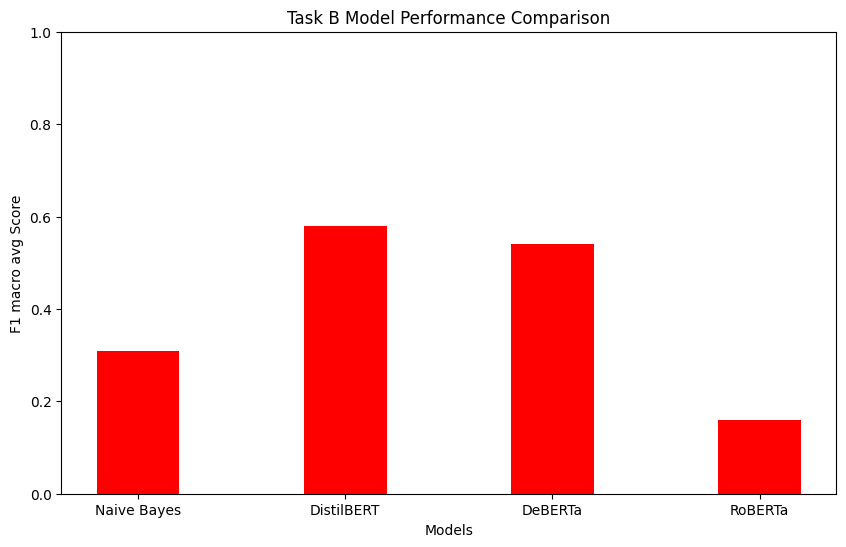

In [ ]:
import matplotlib.pyplot as plt

# List of model names
model_names = ["Naive Bayes", "DistilBERT", "DeBERTa", "RoBERTa"]

# List of accuracy values for each model
accuracy_values = [0.31, 0.58, 0.54, 0.16]  # Replace with actual accuracy values

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_values, color='red', width=0.4)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('F1 macro avg Score')
plt.title('Task B Model Performance Comparison')
plt.ylim(0, 1)  # Set y-axis limits

# Display the plot
plt.show()